# Time series mini-project
_Maryam El Yaagoubi_

_Homère Tandeau de Marsac_

_MVA 2025-2026_

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


## Data handling

In [9]:
def inspect_dutch_politics(path="dutch_politics.csv", n=10):
    df = pd.read_csv(path)

    print("shape:", df.shape)
    print("\ncolumns:")
    print(df.columns.tolist())

    print("\ndtypes:")
    print(df.dtypes)

    print("\nmissing values:")
    print((df.isna().mean() * 100).round(2))

    print("\nhead:")
    print(df.head(n))

    print("\nrandom sample:")
    print(df.sample(n, random_state=0))

    print("\nduplicated rows:", df.duplicated().sum())

    print(df)


In [11]:
inspect_dutch_politics()

shape: (988, 13)

columns:
['Unnamed: 0', 'Orr', 'Vvd', 'Cda', 'D66', 'Pvda', 'Glef', 'wnOrr', 'wnVvd', 'wnCda', 'wnD66', 'wnPvda', 'wnGlef']

dtypes:
Unnamed: 0      int64
Orr           float64
Vvd           float64
Cda           float64
D66           float64
Pvda          float64
Glef          float64
wnOrr           int64
wnVvd           int64
wnCda           int64
wnD66           int64
wnPvda          int64
wnGlef          int64
dtype: object

missing values:
Unnamed: 0    0.0
Orr           0.0
Vvd           0.0
Cda           0.0
D66           0.0
Pvda          0.0
Glef          0.0
wnOrr         0.0
wnVvd         0.0
wnCda         0.0
wnD66         0.0
wnPvda        0.0
wnGlef        0.0
dtype: float64

head:
   Unnamed: 0     Orr     Vvd     Cda     D66    Pvda    Glef  wnOrr  wnVvd  \
0           1  6.3636  5.0101  4.9643  3.1500  2.7500  1.9474     22    100   
1           2  6.2000  4.9846  4.9923  3.4324  2.6868  2.0714     21    135   
2           3  6.0455  4.9615  5.0844  

Source: https://www.kaggle.com/datasets/krish525/open-time-series-data/data

The dataset contains **988 observations** and **13 variables**.  
Each row corresponds to **one survey week**. The data are ordered in time; no explicit calendar dates are provided, and the time index is implicit.

There are **no missing values** and **no duplicated rows**.


### Variables

#### Time index
- **`Unnamed: 0`**  
  Integer index, strictly increasing from 1 to 988.  
  It is used as a proxy for time (one unit = one week).


#### Ideological position variables (continuous)

These variables represent the **average left–right ideological self-placement** of respondents associated with major Dutch political parties during a given week:

- **`Orr`**
- **`Vvd`**
- **`Cda`**
- **`D66`**
- **`Pvda`**
- **`Glef`**



#### Survey weight variables (counts)

For each ideological series, a corresponding integer variable is provided:

- **`wnOrr`**
- **`wnVvd`**
- **`wnCda`**
- **`wnD66`**
- **`wnPvda`**
- **`wnGlef`**


The variables `Orr`, `Vvd`, `Cda`, `D66`, `Pvda`, and `Glef` correspond to Dutch political parties. 
Each variable represents the weekly average left–right ideological self-placement of respondents associated with the corresponding party. 

The variables `wnOrr`, `wnVvd`, `wnCda`, `wnD66`, `wnPvda`, and `wnGlef` denote the number of respondents (or effective sample size) used to compute each weekly average. 


### Classification task

For each time index $t$, a feature vector $X_t$ is constructed from a rolling window of past observations. The label $y_t$ is defined using future values of a selected ideological series (e.g. `Orr`), ensuring a strict temporal separation between inputs and targets. A typical choice is a directional label indicating whether the ideological position increases or decreases over a fixed horizon $h$:
$$
y_t = \mathbb{1}\left[ x_{t+h} - x_t > 0 \right].
$$
This yields a genuine time-series classification problem, where discrete future outcomes are predicted from historical data.

### Feature construction

To obtain a feature space in which feature selection is non-trivial, the original time series are expanded into a higher-dimensional representation. For each ideological variable, lagged values and window-based summaries are computed over the past $W$ time steps. The idea is to captsre short- and medium-term dynamics (no long term cuz df is too small).


### Application of Laplacian Score

Laplacian Score is applied to the resulting feature matrix prior to classification. Since the method is unsupervised, it operates solely on the feature space $X$, without access to the labels. An affinity graph is constructed using k-nearest neighbors in the expanded feature space, and features are ranked according to their ability to preserve the local geometric structure of the data manifold.

In this context, Laplacian Score favors features that are smooth with respect to the intrinsic dynamics of the multivariate time series, while penalizing noisy or weakly structured features. The selected subset is then used as input to a supervised classifier. This separation between unsupervised feature selection and supervised learning makes it possible to assess how well manifold-preserving features support downstream prediction.


In [20]:
# laplace input
def make_ts_classification_df(
    df: pd.DataFrame,
    *,
    target_col: str = "Orr",
    horizon: int = 4,
    lags: int = 12,
    roll_windows=(4, 12),
    use_weights: bool = True,
) -> tuple[pd.DataFrame, pd.Series]:
    data = df.copy()

    # sort chronologically
    tcol = "Unnamed: 0"
    if tcol not in data.columns:
        raise ValueError(f"Expected '{tcol}' column to be present.")
    data = data.sort_values(tcol).reset_index(drop=True)

    # Base signals 
    parties = ["Orr", "Vvd", "Cda", "D66", "Pvda", "Glef"]
    parties = [c for c in parties if c in data.columns]
    if target_col not in parties:
        raise ValueError(f"target_col='{target_col}' must be one of {parties} (present in df).")

    wcols = [f"wn{c}" for c in ["Orr", "Vvd", "Cda", "D66", "Pvda", "Glef"]]
    wcols = [c for c in wcols if c in data.columns]
    base_cols = parties + (wcols if use_weights else [])

    # Features
    X = pd.DataFrame(index=data.index)

    # Lags
    lag_feats = (
        pd.concat({f"lag{j}": data[base_cols].shift(j) for j in range(1, lags + 1)}, axis=1)
          .swaplevel(0, 1, axis=1)
          .sort_index(axis=1)
    )
    lag_feats.columns = [f"{c}_{j}" for c, j in lag_feats.columns]
    X = pd.concat([X, lag_feats], axis=1)

    # 1-step differences 
    diff = data[base_cols].diff(1)
    diff.columns = [f"{c}_diff1" for c in diff.columns]
    X = pd.concat([X, diff], axis=1)

    # Rolling stats on past window (shift(1) to avoid look forward)
    # Here we allow x_t as "available at time t"; rolling uses values up to t.
    for w in roll_windows:
        m = data[base_cols].rolling(w).mean()
        s = data[base_cols].rolling(w).std(ddof=0)
        m.columns = [f"{c}_mean{w}" for c in m.columns]
        s.columns = [f"{c}_std{w}" for c in s.columns]
        X = pd.concat([X, m, s], axis=1)

    # Label
    future = data[target_col].shift(-horizon)
    y = (future - data[target_col] > 0).astype(int)

    # Keep only rows where all required features and y are defined
    valid = y.notna()
    valid &= ~X.isna().any(axis=1)
    X = X.loc[valid].copy()
    y = y.loc[valid].copy()

    return X, y


In [21]:
def laplacian_score(
    X: np.ndarray,
    *,
    n_neighbors: int = 10,
    t: float | None = None,
) -> np.ndarray:
    """
    Steps :
    - build kNN affinity S with heat kernel:
        S_ij = exp(-||x_i - x_j||^2 / t) if i in kNN(j), else 0
    - D = diag(S 1), L = D - S
    - center each feature with respect to D:
        f~ = f - (1^T D f)/(1^T D 1) * 1
    - score(f) = (f~^T L f~)/(f~^T D f~)

    """
    n, d = X.shape
    if n < 3:
        raise ValueError("Need at least 3 samples to build a meaningful kNN graph.")

    # Standardize before distance-based graph construction
    Xs = StandardScaler(with_mean=True, with_std=True).fit_transform(X)

    # kNN (directed graph)
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric="euclidean")
    nn.fit(Xs)
    dist, idx = nn.kneighbors(Xs, return_distance=True)

    # Drop self-neighbor at position 0
    dist = dist[:, 1:]
    idx = idx[:, 1:]

    # kernel widh = median of squared kNN distances 
    if t is None:
        t = np.median(dist**2)
        if not np.isfinite(t) or t <= 0:
            t = 1.0

    # Build sparse affinity in dense form (n=~1e3 is fine)
    S = np.zeros((n, n), dtype=float)
    w = np.exp(-(dist**2) / t)
    rows = np.repeat(np.arange(n), n_neighbors)
    cols = idx.reshape(-1)
    S[rows, cols] = w.reshape(-1)

    # stab the graph
    S = 0.5 * (S + S.T)

    dvec = S.sum(axis=1)                 # D(i,i)
    L = np.diag(dvec) - S                # Laplacian

    # D-weighted centering
    F = X.astype(float)
    denom_1 = dvec.sum()
    if denom_1 <= 0:
        raise ValueError("Graph degree sum is zero; try different n_neighbors / scaling.")
    mean_w = (dvec @ F) / denom_1        # shape (d,)
    Ftil = F - mean_w                    # broadcast

    # Compute scores for all features:
    # num_j = f~_j^T L f~_j = sum_i f~_ij * (L f~_j)_i
    # den_j = f~_j^T D f~_j = sum_i d_i * f~_ij^2
    LF = L @ Ftil                        # (n,d)
    num = np.sum(Ftil * LF, axis=0)

    den = np.sum((dvec[:, None] * (Ftil**2)), axis=0)

    # Avoid division by ~0 variance features (assign +inf so they rank last)
    eps = 1e-12
    scores = num / np.maximum(den, eps)
    scores[den < eps] = np.inf

    return scores


In [22]:
def select_features_by_laplacian(
    X: pd.DataFrame,
    *,
    k: int,
    n_neighbors: int = 10,
    t: float | None = None,
) -> tuple[pd.Index, pd.Series]:
    """
    Rank features by Laplacian Score and return the top-k (smallest scores)
    """
    scores = laplacian_score(X.to_numpy(), n_neighbors=n_neighbors, t=t)
    scores_s = pd.Series(scores, index=X.columns).sort_values()
    selected = scores_s.index[:k]
    return selected, scores_s


In [23]:
df = pd.read_csv("dutch_politics.csv")

# Build TS classification design matrix (many candidate features) + labels
X, y = make_ts_classification_df(
    df,
    target_col="Orr",
    horizon=4,      # predict direction over next 4 weeks
    lags=12,        # use last 12 weeks
    roll_windows=(4, 12),
    use_weights=True
)

# Time-aware split, we don't want to peek into the future
split = int(0.7 * len(X))
X_train, y_train = X.iloc[:split], y.iloc[:split]
X_test,  y_test  = X.iloc[split:], y.iloc[split:]

# Unsupervised feature selection k=30
selected_cols, lap_scores = select_features_by_laplacian(
    X_train,
    k=30,
    n_neighbors=10,
    t=None
)

print("Selected features (top 30 by smallest Laplacian Score):")
print(selected_cols.tolist())

print("\nTop 10 scores:")
print(lap_scores.head(10))


X_train_sel = X_train[selected_cols]
X_test_sel  = X_test[selected_cols]


Selected features (top 30 by smallest Laplacian Score):
['Cda_mean12', 'Orr_mean12', 'wnD66_mean12', 'Vvd_mean12', 'Cda_mean4', 'wnVvd_mean12', 'Pvda_mean12', 'wnD66_mean4', 'wnPvda_mean12', 'wnCda_mean12', 'wnGlef_mean12', 'wnVvd_mean4', 'wnOrr_mean12', 'Pvda_mean4', 'wnPvda_mean4', 'Vvd_mean4', 'Orr_mean4', 'wnD66_lag1', 'wnD66_lag11', 'wnD66_lag10', 'Cda_lag8', 'wnD66_lag9', 'wnD66_lag3', 'Glef_mean12', 'Cda_lag7', 'wnD66_lag5', 'Cda_lag5', 'Cda_lag6', 'wnD66_lag6', 'Cda_lag10']

Top 10 scores:
Cda_mean12       0.032823
Orr_mean12       0.042303
wnD66_mean12     0.047822
Vvd_mean12       0.069471
Cda_mean4        0.072019
wnVvd_mean12     0.073729
Pvda_mean12      0.074281
wnD66_mean4      0.088323
wnPvda_mean12    0.091618
wnCda_mean12     0.095228
dtype: float64


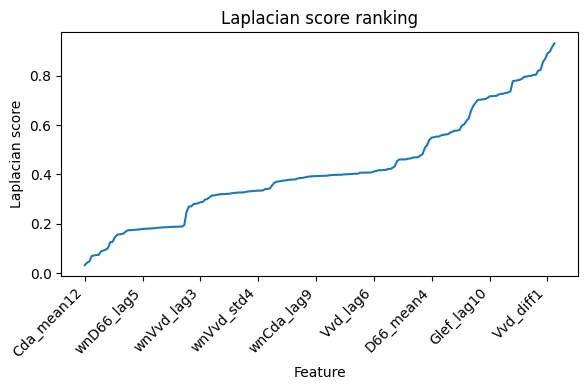

In [24]:
plt.figure(figsize=(6, 4))
ax = lap_scores.sort_values().plot(logy=False)
plt.ylabel("Laplacian score")
plt.xlabel("Feature")
plt.title("Laplacian score ranking")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Laplacian was presented in the paper as a way to preserve feature manifold geometry, let's check for that here:

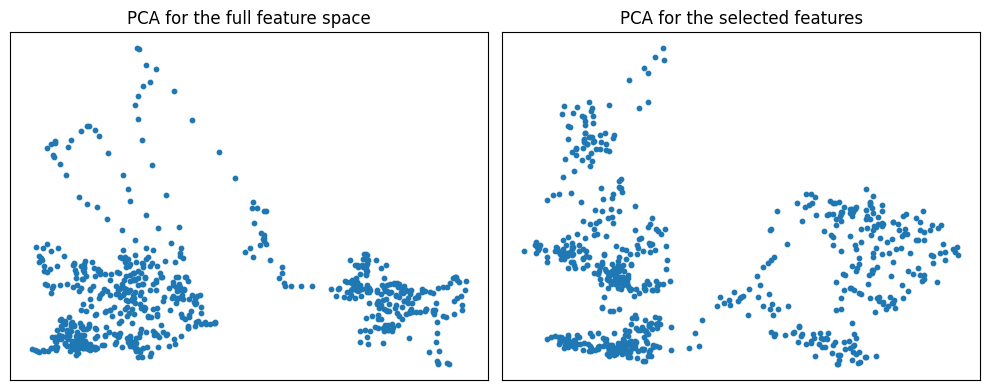

In [28]:
# Standardize for geometry comparison
Xs = StandardScaler().fit_transform(X_train)
Xs_sel = StandardScaler().fit_transform(X_train_sel)

pca_full = PCA(n_components=2).fit_transform(Xs)
pca_sel = PCA(n_components=2).fit_transform(Xs_sel)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(pca_full[:, 0], pca_full[:, 1], s=10)
axes[0].set_title("PCA for the full feature space")

axes[1].scatter(pca_sel[:, 0], pca_sel[:, 1], s=10)
axes[1].set_title("PCA for the selected features")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Geometry is effectively preserved!

In [ ]:
# put feature selection to the test in a classification task
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled  = scaler.transform(X_test_sel)

# classifier
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=20000
)

# no laplace
clf.fit(X_train_scaled, y_train)
pred_full = clf.predict(X_test_scaled)

# using laplace
clf.fit(X_train_sel_scaled, y_train)
pred_sel = clf.predict(X_test_sel_scaled)

# eval
print("Accuracy (full):", accuracy_score(y_test, pred_full))
print("Accuracy (laplace):", accuracy_score(y_test, pred_sel))


Accuracy (full): 0.6450511945392492
Accuracy (selected): 0.5563139931740614
